# Traditional Forecasting of Volatility using the GARCH Framework

In this notebook, we forecast realized volatility using a classical econometric approach — the GARCH(1,1) model — applied to the S&P 500 index.

We begin by computing log returns from historical closing prices, then fit a GARCH(1,1) model to estimate time-varying volatility. The model captures volatility clustering and persistence, which are key characteristics of financial time series.

We then perform out-of-sample forecasting using a rolling window approach and compare the GARCH-implied volatility forecasts against realized volatility computed over a 5-day horizon. Finally, we evaluate the model's forecasting accuracy using error metrics such as RMSE, MAE, and MAPE.


In [ ]:
#Import libraries 
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm


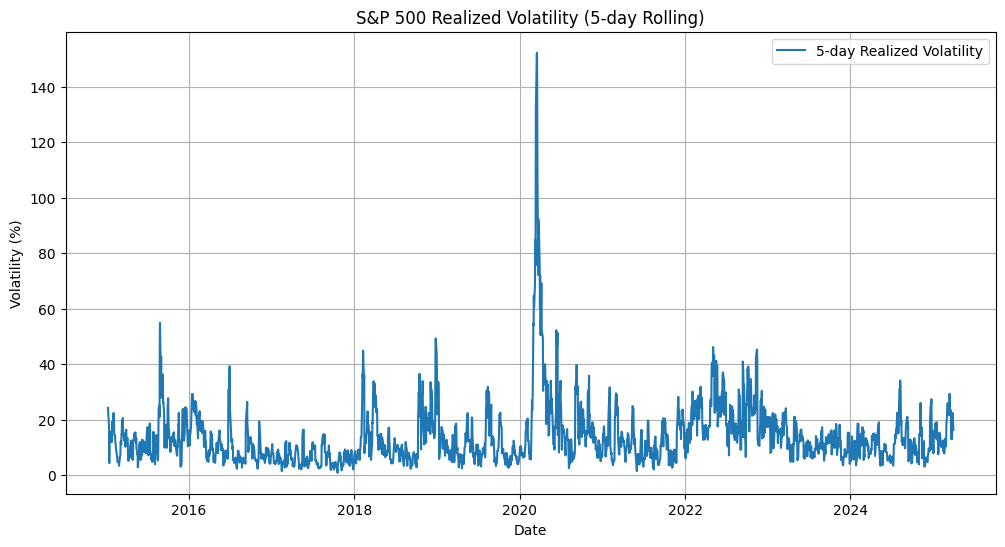

In [49]:
#Get the S&P 500 data from Yahoo Finance
data = yf.download('^GSPC', start='2015-01-01', end='2025-04-01', progress=False)
data = data.ffill()

# Use 'Close' price only
sp_500 = data['Close']

# Compute log returns in percent
log_returns = np.log(sp_500 / sp_500.shift(1)).dropna() * 100  # daily returns (%)

# Compute realized volatility (5-day rolling, annualized)
rolling_volatility_realized = log_returns.rolling(window=5).std() * np.sqrt(252)
rolling_volatility_realized = rolling_volatility_realized.dropna()

# Plot realized volatility
plt.figure(figsize=(12, 6))
plt.plot(rolling_volatility_realized, label='5-day Realized Volatility')
plt.title('S&P 500 Realized Volatility (5-day Rolling)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid()
plt.show()

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3319.60
Distribution:                  Normal   AIC:                           6647.20
Method:            Maximum Likelihood   BIC:                           6670.62
                                        No. Observations:                 2575
Date:                Wed, Apr 02 2025   Df Residuals:                     2574
Time:                        14:54:34   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0770  1.477e-02      5.213  1.858e-07 [4.804e-0

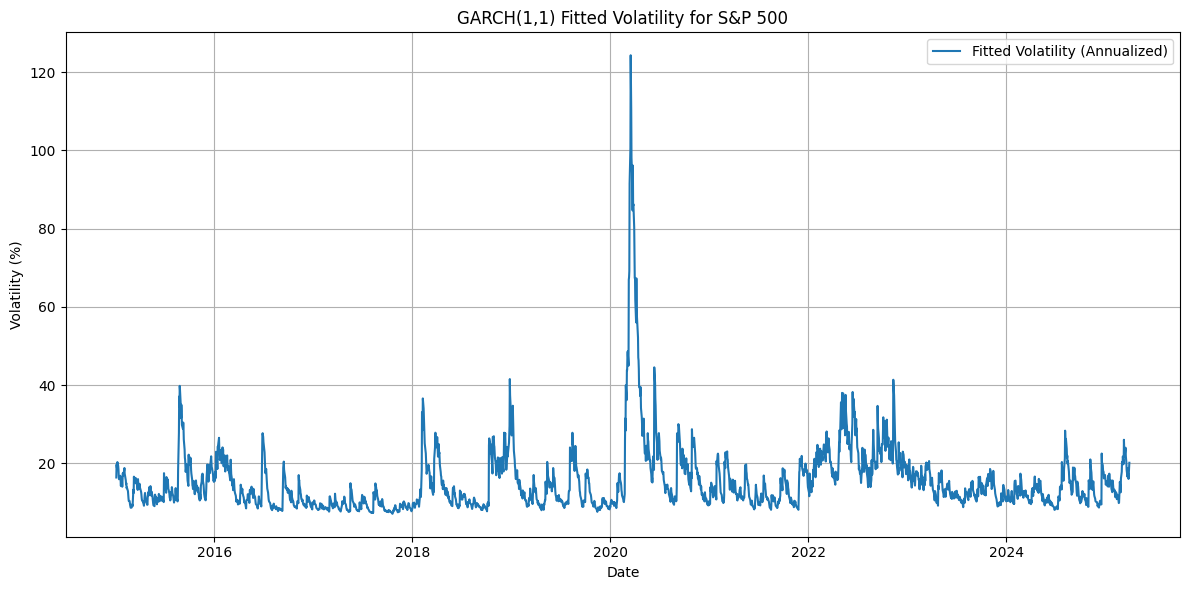

In [50]:
# Fit GARCH(1,1) in-sample
model = arch_model(log_returns, vol='Garch', p=1, q=1, dist='normal')
model_fit = model.fit(disp='off')
print(model_fit.summary())

# Plot fitted conditional volatility (in-sample)
plt.figure(figsize=(12, 6))
plt.plot(model_fit.conditional_volatility * np.sqrt(252), label='Fitted Volatility (Annualized)')
plt.title('GARCH(1,1) Fitted Volatility for S&P 500')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Out-of-Sample testing

100%|██████████| 1574/1574 [00:08<00:00, 179.72it/s]


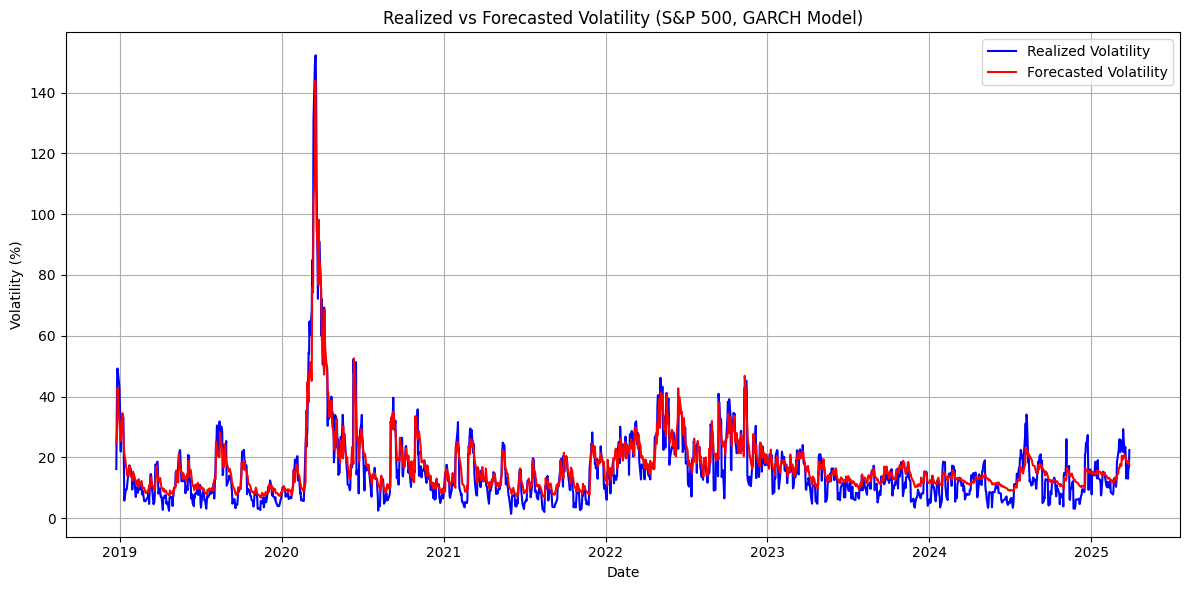

In [53]:
#Rolling forecast (out-of-sample)
window_size = 1000
num_forecasts = 1
rolling_predictions = []
forecast_dates = []

log_returns_series = log_returns.copy()

for i in tqdm(range(window_size, len(log_returns_series) - num_forecasts)):
    train_data = log_returns_series.iloc[i - window_size:i]

    try:
        model = arch_model(train_data, vol='Garch', p=1, q=1, dist='normal')
        model_fit = model.fit(disp='off')
        forecast = model_fit.forecast(horizon=num_forecasts)
        avg_var = forecast.variance.values[-1, :num_forecasts].mean()
        vol_forecast = np.sqrt(avg_var) * np.sqrt(252)
        rolling_predictions.append(vol_forecast)

        forecast_date = log_returns_series.index[i + num_forecasts - 1]
        forecast_dates.append(forecast_date)

    except Exception as e:
        print(f"⚠️ Forecast failed at index {i}: {e}")
        continue

# Create DataFrame of forecasts
rolling_predictions_df = pd.DataFrame(
    rolling_predictions,
    index=forecast_dates,
    columns=["Forecasted Volatility"]
)

# Align realized volatility
realized_vol = rolling_volatility_realized.loc[rolling_predictions_df.index]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label="Realized Volatility", color="blue")
plt.plot(rolling_predictions_df, label="Forecasted Volatility", color="red")
plt.title("Realized vs Forecasted Volatility (S&P 500, GARCH Model)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract forecasted and actual volatilities
y_true = realized_vol.values
y_pred = rolling_predictions_df["Forecasted Volatility"].values

# Compute RMSE, MAE, MAPE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Print results
print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📊 MAPE: {mape:.2f}%")

📊 RMSE: 4.98
📊 MAE: 3.63
📊 MAPE: 90.42%
